In [1]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import Saliency
from captum.attr import GuidedGradCam
from captum.attr import visualization as viz

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = torch.load('Dashboard/model_conv_resnet50.pth', map_location=device)
model = model.eval()

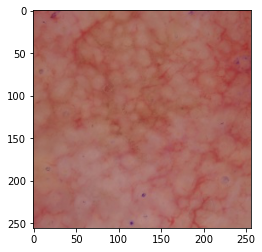

In [3]:
from PIL import Image
from torchvision import transforms
img = Image.open("data/validation/malignant/ISIC_1959939.jpg")

#preprocess = transforms.Compose([
#        transforms.Resize(256),
#        transforms.CenterCrop(224),
#        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#])

#img = preprocess(im)
#img = img.unsqueeze(0)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transformed_img = transform(img)

input = transformed_img.unsqueeze(0)

imgplot = plt.imshow(img)

In [4]:
labels = np.array(open("class.txt").read().splitlines())

In [5]:
input.requires_grad = True
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = labels[pred_label_idx.squeeze_()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: malignant ( 0.7437567710876465 )


In [6]:
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

original_image = inv_normalize(input)
original_image1 = np.transpose(original_image.squeeze().detach().numpy(), (1,2,0))

#_ = viz.visualize_image_attr(None, original_image1, method="original_image", title="Original Image")

# Saliency

In [7]:
saliency = Saliency(model)
grads = saliency.attribute(input, target=pred_label_idx)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))


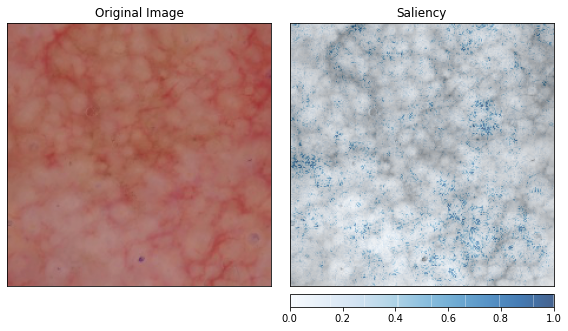

In [8]:
_ = viz.visualize_image_attr_multiple(grads, original_image1, methods=["original_image", "blended_heat_map"],signs=["all", "absolute_value"],
                          show_colorbar=True, titles = ["Original Image", "Saliency"])

# Integrated Gradients

In [9]:
ig = IntegratedGradients(model)
attr_ig = ig.attribute(input, target=pred_label_idx, n_steps=200)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))


In [10]:
#_ = viz.visualize_image_attr(attr_ig, original_image1, method="blended_heat_map",sign="all", show_colorbar=True, title="Overlayed Integrated Gradients")

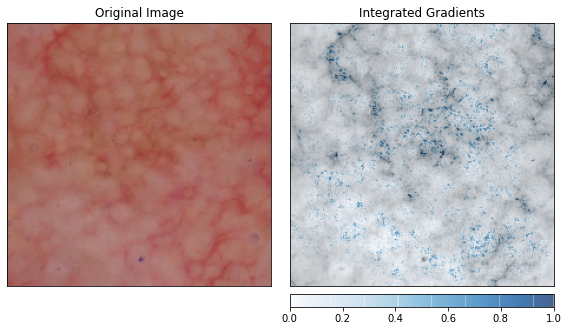

In [11]:
_ = viz.visualize_image_attr_multiple(attr_ig, original_image1, methods=["original_image", "blended_heat_map"],signs=["all", "absolute_value"],
                          show_colorbar=True, titles = ["Original Image", "Integrated Gradients"])

# Gradient Shap

In [12]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)


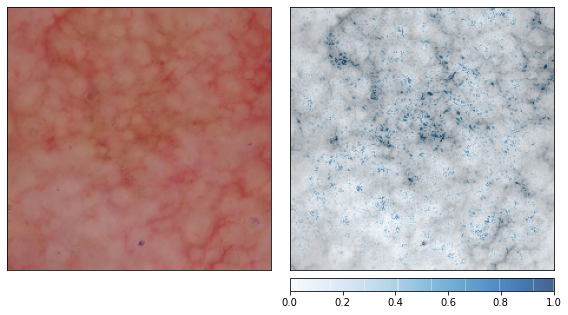

In [13]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      original_image1,
                                      ["original_image", "blended_heat_map"],
                                      ["all", "absolute_value"],
                                      show_colorbar=True)

# Guided GradCAM

In [14]:
guided_gc = GuidedGradCam(model, model.layer4)
attr_guided_gc = guided_gc.attribute(input, target=pred_label_idx)
attr_guided_gc = np.transpose(attr_guided_gc.squeeze().cpu().detach().numpy(), (1, 2, 0))

/home/jyao/miniconda3/envs/pytorch/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


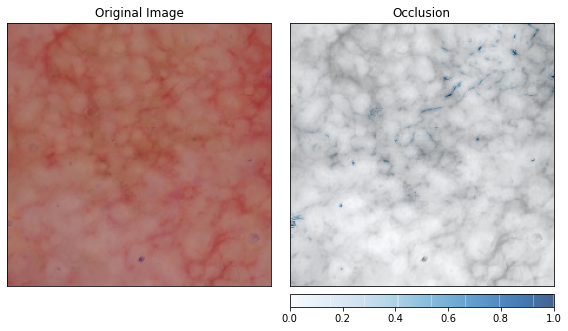

In [15]:
_ = viz.visualize_image_attr_multiple(attr_guided_gc, original_image1, methods=["original_image", "blended_heat_map"],signs=["all", "absolute_value"],
                          show_colorbar=True, titles = ["Original Image", "Occlusion"])

# Occlusion

In [16]:
occlusion = Occlusion(model)
attributions_occ = occlusion.attribute(input, strides = (3, 8, 8), target=pred_label_idx, sliding_window_shapes=(3,15, 15), baselines=0)
attributions_occ = np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0))


In [17]:
#_ = viz.visualize_image_attr(attributions_occ, original_image1, method="blended_heat_map",sign="absolute_value", show_colorbar=True, title="Occlusion")

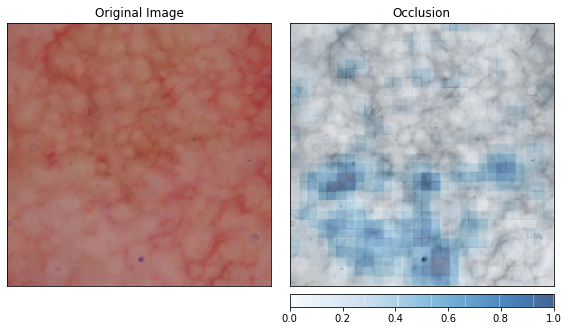

In [18]:
_ = viz.visualize_image_attr_multiple(attributions_occ, original_image1, methods=["original_image", "blended_heat_map"],signs=["all", "absolute_value"],
                          show_colorbar=True, titles = ["Original Image", "Occlusion"])

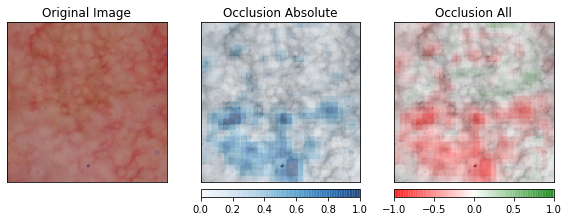

In [19]:
_ = viz.visualize_image_attr_multiple(attributions_occ, original_image1, methods=["original_image", "blended_heat_map", "blended_heat_map"],signs=["all", "absolute_value", "all"],
                          show_colorbar=True, titles = ["Original Image", "Occlusion Absolute", "Occlusion All"])